In [1]:
import logging

# Our imports
import emission.core.get_database as edb
import emission.analysis.modelling.tour_model.cluster_pipeline as pipeline
import emission.analysis.modelling.tour_model.similarity as similarity
import emission.analysis.modelling.tour_model.featurization as featurization
import emission.analysis.modelling.tour_model.representatives as representatives
import emission.storage.decorations.analysis_timeseries_queries as esda
import pandas as pd
from numpy import *
import confirmed_trips_eval_bins_clusters as evaluation
from sklearn import metrics
from pandas.testing import assert_frame_equal
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

storage not configured, falling back to sample, default configuration
Connecting to database URL localhost


In [2]:
participant_uuid_obj = list(edb.get_profile_db().find({"install_group": "participant"}, {"user_id": 1, "_id": 0}))
all_users = [u["user_id"] for u in participant_uuid_obj]

In [3]:
radius = 100

In [4]:
query_day = []

In [5]:
query_month = []

In [6]:
def match_day(trip,bin):
    if bin:
        t = filter_trips[bin[0]]
        if trip['data']['start_local_dt']['year']==t['data']['start_local_dt']['year']and trip['data']['start_local_dt']['month']==t['data']['start_local_dt']['month']and trip['data']['start_local_dt']['day']==t['data']['start_local_dt']['day']:
            return True
    return False

In [7]:
def match_month(trip,bin):
    if bin:
        t = filter_trips[bin[0]]
        if trip['data']['start_local_dt']['year']==t['data']['start_local_dt']['year']and trip['data']['start_local_dt']['month']==t['data']['start_local_dt']['month']:
            return True
    return False

In [8]:
def plot_day(query_day_ls):    
    query_day_ls_df = pd.DataFrame(data = query_day_ls)
    query_day_df=query_day_ls_df.value_counts(sort = False).rename_axis('query times').to_frame('frequecy').reset_index()
    query_day_df.set_index(['query times'], inplace=True)
    query_day=query_day_df.plot(kind = 'bar',title='query times in a day')
    query_day.yaxis.set_major_locator(MaxNLocator(integer=True))

In [9]:
for i in range(len(all_users)):
    user = all_users[i]
    filter_trips,sim = evaluation.filter_data(user,radius)
    logging.debug("len(filter_trips)is %s "% len(filter_trips))

    # filter out users that don't have valid labeled trips
    if len(filter_trips) == 0:
        query_day.append(NaN)
        query_month.append(NaN)
        continue
        
    sim.bin_data()
    sim.delete_bins()
    bins = sim.bins
    
    # collect query trips indices above cutoff
    ab_trip_ls = []
    for bin in bins:
        early_trip = filter_trips[bin[0]]
        trip_index = 0
        for i in range(1,len(bin)):
            compare_trip = filter_trips[bin[i]]
            if early_trip['data']['start_local_dt']['year']>compare_trip['data']['start_local_dt']['year']:
                early_trip = compare_trip
                trip_index = i
            elif early_trip['data']['start_local_dt']['year']==compare_trip['data']['start_local_dt']['year'] and early_trip['data']['start_local_dt']['month']>compare_trip['data']['start_local_dt']['month']:
                early_trip = compare_trip
                trip_index = i
            elif early_trip['data']['start_local_dt']['year']==compare_trip['data']['start_local_dt']['year'] and early_trip['data']['start_local_dt']['month']==compare_trip['data']['start_local_dt']['month'] and early_trip['data']['start_local_dt']['day']>compare_trip['data']['start_local_dt']['day']:
                early_trip = compare_trip
                trip_index = i
        ab_trip_ls.append(bin[trip_index])


    
    # bins below cutoff
    bl_bins = sim.below_cutoff
    
    # collect query trips indices below cutoff
    bl_trip_ls = []
    for bin in bl_bins:
        for index in bin:
            bl_trip_ls.append(index)
            
    # whole list of query trips indices
    query_trips_ls=ab_trip_ls+bl_trip_ls    
    
    # collect query times in a day
    bin_day = []
    for trip_index in query_trips_ls:
        added = False
        trip = filter_trips[trip_index]
        for bin in bin_day:
            if match_day(trip,bin):
                bin.append(trip_index)
                added = True
        if not added:
            bin_day.append([trip_index])
    query_day_ls = []
    for bin in bin_day:
        query_day_ls.append(len(bin))

    # collect query times in a day for every user
    query_day.append(query_day_ls)
    
    
    # collect query times in a month
    bin_month = []
    for trip_index in query_trips_ls:
        added = False
        trip = filter_trips[trip_index]
        for bin in bin_month:
            if match_month(trip,bin):
                bin.append(trip_index)
                added = True
        if not added:
            bin_month.append([trip_index])
        query_month_ls = []
    for bin in bin_month:
        query_month_ls.append(len(bin))

    # collect query times in a month for every user
    query_month.append(query_month_ls)


In [10]:
query_day

[[5,
  6,
  6,
  9,
  8,
  1,
  1,
  1,
  4,
  1,
  1,
  2,
  2,
  1,
  3,
  2,
  2,
  2,
  2,
  1,
  2,
  2,
  2,
  2,
  3,
  2,
  1,
  2,
  2,
  2,
  1,
  1,
  1,
  3,
  2,
  2,
  2,
  1,
  1,
  5,
  4,
  3,
  2,
  4,
  2,
  4,
  2,
  3,
  1],
 nan,
 [2,
  4,
  3,
  4,
  2,
  4,
  7,
  2,
  5,
  6,
  3,
  3,
  9,
  1,
  2,
  7,
  2,
  5,
  2,
  6,
  1,
  1,
  2,
  1,
  1,
  6,
  2,
  3,
  6,
  2,
  1,
  2,
  5,
  1,
  3,
  3,
  9,
  4,
  6,
  4,
  5,
  2,
  3,
  4,
  1,
  1,
  3,
  1,
  1],
 [3,
  2,
  1,
  1,
  3,
  3,
  3,
  3,
  1,
  4,
  2,
  4,
  2,
  2,
  4,
  1,
  1,
  2,
  2,
  4,
  2,
  2,
  3,
  2,
  1,
  2,
  4,
  4,
  1,
  1,
  1,
  2,
  1,
  2,
  2,
  2,
  2,
  1,
  1,
  2,
  1,
  1,
  2,
  3,
  2],
 [2, 1, 2, 2],
 [2,
  3,
  3,
  1,
  3,
  3,
  2,
  2,
  2,
  3,
  2,
  2,
  2,
  3,
  2,
  1,
  3,
  1,
  5,
  2,
  1,
  2,
  2,
  3,
  2,
  1,
  5,
  3,
  4,
  1,
  2,
  2,
  5,
  2,
  4,
  2,
  2,
  3,
  1,
  3,
  2,
  1,
  1,
  1],
 [2, 3, 3, 1, 2, 2, 4, 2, 2, 4, 2, 2, 2,

In [11]:
query_month

[[26, 61, 18, 7, 12],
 nan,
 [36, 52, 75],
 [42, 28, 25],
 [2, 3, 2],
 [14, 38, 50],
 [18, 7, 24, 1],
 [131, 148, 4],
 [71, 91, 28, 8],
 [48, 50, 47],
 [16, 2],
 nan,
 [153, 182, 152]]

### Plot query times in a day

Note: frequecy represents the number of days have specific query times. Each graph represents query times for a user

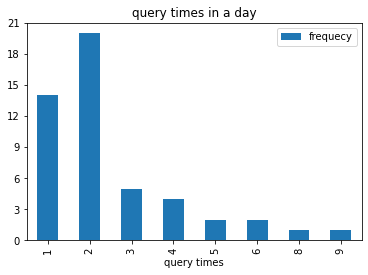

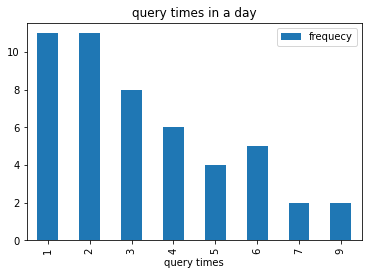

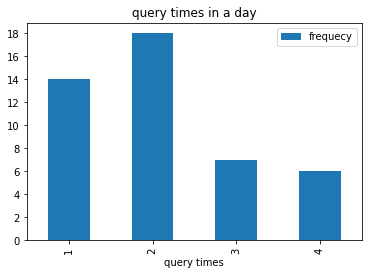

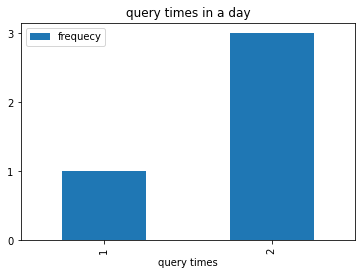

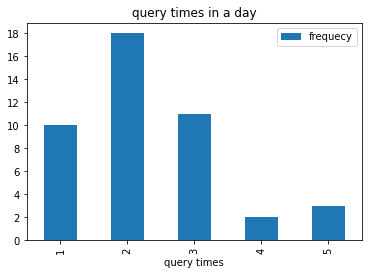

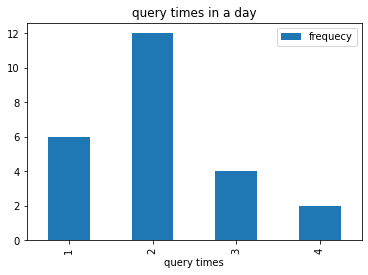

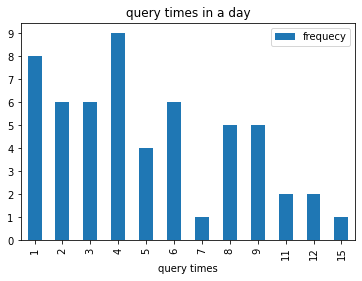

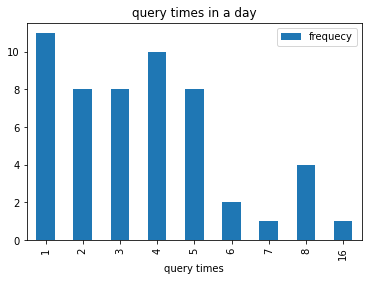

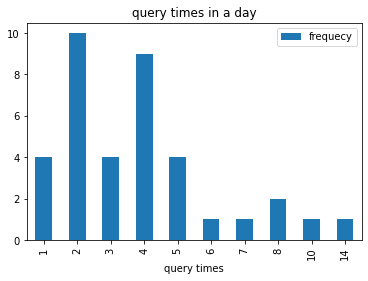

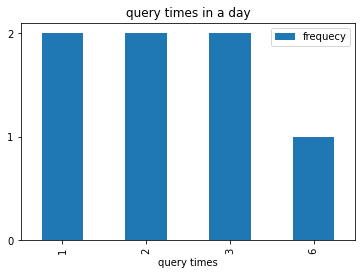

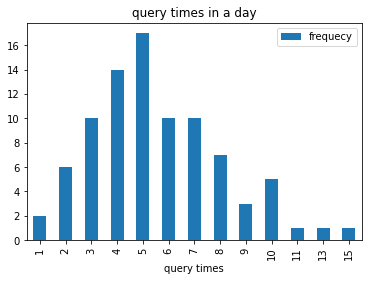

In [12]:
for i in range (len(query_day)):
    if query_day[i] is not NaN:
        plot_day(query_day[i])

### Plot query times in a month

Note: not all users have data on the same number of months. Each graph represents query times for a user in a month.

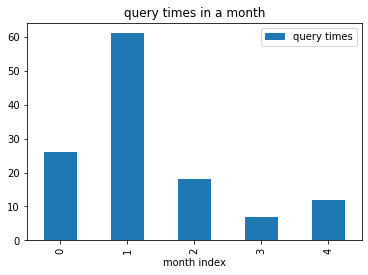

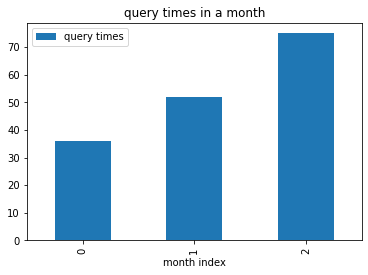

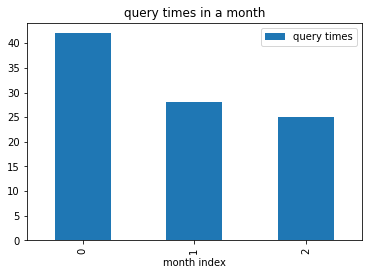

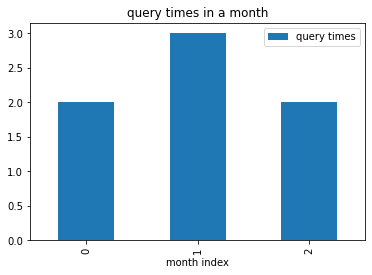

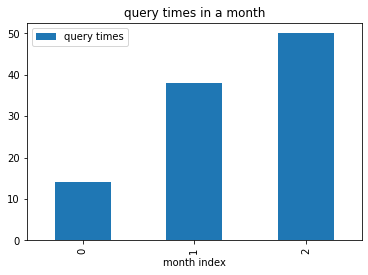

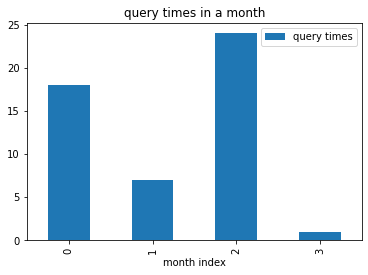

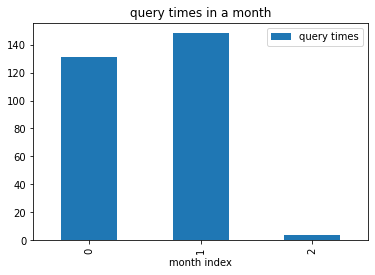

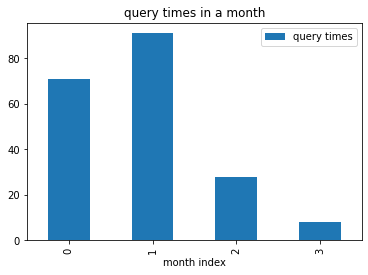

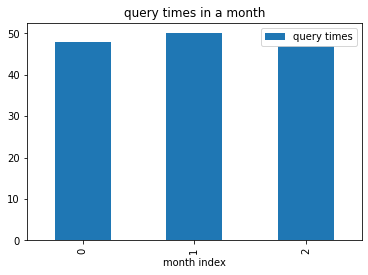

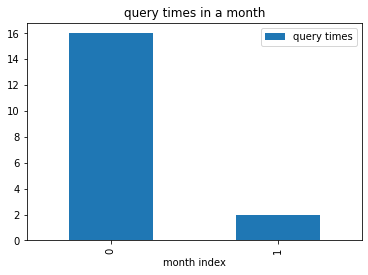

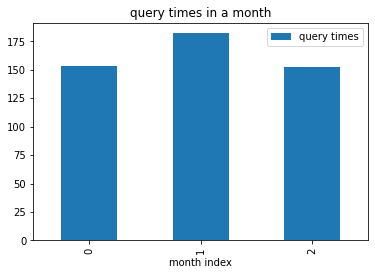

In [13]:
for i in range (len(query_month)):
    if query_month[i] is not NaN:
        query_month_df = pd.DataFrame(data = {'query times':query_month[i]})
        query_month_df.plot(xlabel='month index',kind = 'bar',title='query times in a month')